In [1]:
import numpy as np
import math
import itertools
import stats
import pickle

In [139]:
def IntToSpins(i,nx_ny):
    (nx,ny)=nx_ny
    numSpins=nx*ny
    myString=format(i, '#0'+str(numSpins+2)+'b')[2:]
    spins=np.reshape(np.array([1 if i=='1' else -1 for i in myString]),(nx,ny))
    return spins


def DeltaE(spins,mySpin):
    Nx,Ny=np.shape(spins)
    (nx,ny)=mySpin
    nxp1=(nx+1)%Nx
    nxm1=(nx-1)%Nx
    nyp1=(ny+1)%Ny
    nym1=(ny-1)%Ny
    return 2*spins[(nx,ny)]*(spins[(nxp1,ny)]+spins[(nxm1,ny)]+spins[(nx,nyp1)]+spins[(nx,nym1)])

class Observables:
    def __init__(self):
        self.mag=[]
        self.mag2=[]
        self.mag2_coarse=[]
        self.energy_coarse=[]
        self.energy=[]

L=27*3       
x,y=np.indices((L,L))
red=np.logical_and((x+y) % 2==0   , np.logical_and(x<L-1,y<L-1))
red[L-1,L-1]=True
blue=np.logical_and((x+y) % 2==1   , np.logical_and(x<L-1,y<L-1))
green=np.logical_and((x+y) % 2==0   , np.logical_or(x==L-1,y==L-1))
green[L-1,L-1]=False
yellow=np.logical_and((x+y) % 2==1   , np.logical_or(x==L-1,y==L-1))


def deltaE_c(spins,color):
    rightSpins=np.roll(spins,1,axis=0)
    leftSpins=np.roll(spins,-1,axis=0)
    upSpins=np.roll(spins,-1,axis=1)
    downSpins=np.roll(spins,1,axis=1) 
    energy=2*(rightSpins[color]+upSpins[color]+downSpins[color]+leftSpins[color])*spins[color]
    return energy        
        
def Energy(spins):
    rightSpins=np.roll(spins,1,axis=0)
    downSpins=np.roll(spins,1,axis=1)
    return np.sum(spins*rightSpins*-1)+np.sum(spins*downSpins*-1)

def RunIsing(params):
    (Nx,Ny)=params["Nx"],params["Ny"]
    N=Nx*Ny
    #spins=IntToSpins(0,(Nx,Ny))
    spins=np.zeros((Nx,Ny))
    o=Observables()
    beta=params["beta"]
    s=params["NumSweeps"]
    for sweep in range(0,s):
        for step in range(0,N):
            flip_x=np.random.randint(Nx)
            flip_y=np.random.randint(Ny)
            if (np.exp(-beta*DeltaE(spins,(flip_x,flip_y)))>np.random.random()):
                spins[flip_x,flip_y]*=-1
        if sweep>10:
            o.mag2.append(np.sum(spins)**2)
            o.mag.append(np.sum(spins))
            o.energy.append(Energy(spins))
    return o


def CoarseGrain(spins,Nx,Ny):
    return np.reshape(np.array([(1 if np.sum(spins[3*i:3*(i+1),3*j:3*(j+1)]) > 0 else -1)  for (i,j) in itertools.product(range(0,Nx//3),range(0,Ny//3))]),(Nx//3,Ny//3))

def RunIsingFast(params):
    (Nx,Ny)=params["Nx"],params["Ny"]
    N=Nx*Ny
    spins=IntToSpins(0,(Nx,Ny))
    o=Observables()
    beta=params["beta"]
    for sweep in range(0,params["NumSweeps"]):
        for color in [red,green,yellow,blue]:
            dE=np.exp(-beta*deltaE_c(spins,color))
            dE=1.0/(1.0+1.0/dE)
            toFlip=dE<np.random.random(np.shape(dE))
            spins[color] = (toFlip*2-1)*spins[color]
        if sweep>10:
            o.mag2.append(np.sum(spins)**2)
            o.energy.append(Energy(spins))
            o.mag.append(np.sum(spins))
            coarse_lattice=CoarseGrain(spins,Nx,Ny)
            o.mag2_coarse.append(np.sum(coarse_lattice)**2)
            o.energy_coarse.append(Energy(coarse_lattice))
    return o



params=dict()
params["NumSweeps"]=1000
params["beta"]=0.5
params["Nx"]=27*3
params["Ny"]=27*3
#%time o=RunIsing(params)
#print(np.average(o.mag2)/((params["Nx"]*params["Ny"])**2))
%time o=RunIsingFast(params)
print(np.average(o.mag2)/((params["Nx"]*params["Ny"])**2))

CPU times: user 5.57 s, sys: 100 ms, total: 5.67 s
Wall time: 5.94 s
0.8337404291734919


In [277]:
import pickle
f=open('data.pickle', 'wb')

In [278]:
pickle.dump(data, f)

In [270]:
params=dict()
#data=dict()
params["NumSweeps"]=1000000
params["Nx"]=27*3
params["Ny"]=27*3
#myData=[]
#myO=[]
Nxy=params["Nx"]*params["Ny"]

#for beta in np.arange(0,1,0.01):
for beta in np.arange(0.4407,0.4415,0.0001):
    params["beta"]=beta
    o=RunIsingFast(params)
    data[beta]=dict()
    o.mag2=np.array(o.mag2)
    o.mag=np.array(o.mag)
    o.energy=np.array(o.energy)
    o.mag2_coarse=np.array(o.mag2_coarse)
    o.energy_coarse=np.array(o.energy_coarse)
    data[beta]['M2']=stats.Stats(o.mag2/Nxy**2)
    data[beta]['M']=stats.Stats(o.mag/Nxy)
    data[beta]['E']=stats.Stats(o.energy/Nxy)  
    data[beta]['M2_coarse']=stats.Stats(o.mag2_coarse/((Nxy//9)**2))
    data[beta]['E_coarse']=stats.Stats(o.energy_coarse/(Nxy//9))
#    myData.append(np.average(o.mag2)/((params["Nx"]*params["Ny"])**2))   
#    myO.append(np.average(o.mag)/(params["Nx"]*params["Ny"]))
    print(beta,np.average(o.mag2)/((params["Nx"]*params["Ny"])**2))

0.4407 0.35929120025289746


KeyboardInterrupt: 

In [146]:
print(data[0])

{'M2': (0.00015479338792287608, 4.653394910007596e-08, 2.1656939176500475e-06, 1.006807069331522), 'M': (0.0002120759904939787, 0.00015474841169713208, 0.0001269088240153438, 1.0396315543367485), 'E': (0.00015102727922220311, 0.0003131197629217867, 0.00017704930780806097, 1.0), 'M2_coarse': (0.0013852960600250627, 3.671890285648449e-06, 1.9197867704223576e-05, 1.0026244844269026), 'E_coarse': (-0.0008830014799544245, 0.0027155412560604174, 0.0005213954009065836, 1.0)}


### Specifc Heat

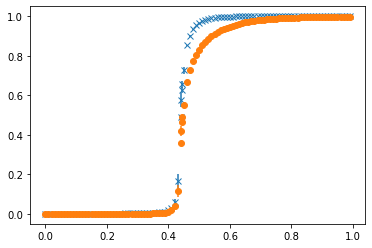

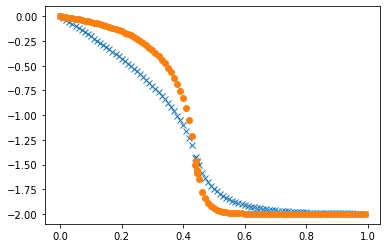

[0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.0007 0.0033 0.001  0.005  0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.01  ]


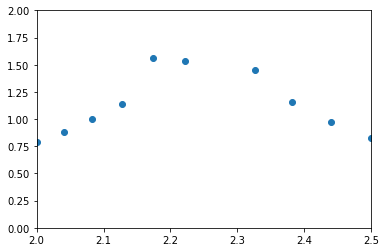

[-0.14820095  0.10050528]


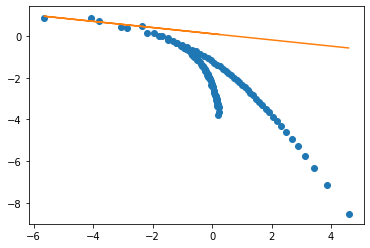

In [14]:
def GetMe(s,data):
    x=[]
    y=[]
    error=[]
    keys=list(data.keys())
    keys.sort()
    for key in keys:
        x.append(key)
        y.append(data[key][s][0])
        error.append(data[key][s][2])
    return (np.array(x),np.array(y),np.array(error))

x,y,e=GetMe('M2_coarse',data)
plt.errorbar(x,y,e,fmt='x')
x,y,e=GetMe('M2',data)
plt.errorbar(x,y,e,fmt='o')
plt.show()

x,y,e=GetMe('E',data)
plt.errorbar(x,y,e,fmt='x')
x,y,e=GetMe('E_coarse',data)
plt.errorbar(x,y,e,fmt='o')
plt.show()


betas,E,e=GetMe('E',data)
print(betas[1:]-betas[:-1])
dEdb=(E[1:]-E[:-1])/(betas[1:]-betas[:-1])
s=-dEdb[0:]*betas[1:]**2
t=1/betas[1:]
plt.plot(t,s,'o')
plt.xlim(2,2.5)
plt.ylim(0,2)
plt.show()
tc=1./0.44068679350977147
xx=np.log(np.abs(t-tc)[s>0])
yy=np.log(s[s>0])
plt.plot(xx,yy,'o')
line=np.polyfit(xx[xx<-3],yy[xx<-3],1)
print(line)
plt.plot(xx,xx*line[0]+line[1])

### Magnetization )beta)

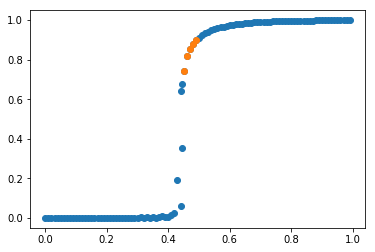

0.1209622490326108


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


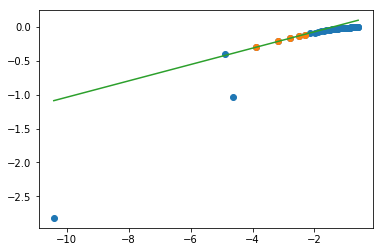

In [272]:
x,y,e=GetMe('M',data)
y=np.abs(y)
plt.plot(x,y,'o')
#cut=np.logical_and(np.logical_and(x>0.440,x<0.5),y>0.4)
cut=np.logical_and(x>0.445, x<0.5)
plt.plot(x[cut],y[cut],'o')
#plt.xlim(0.4,0.5)
plt.show()


xx=np.log(1-(0.44068679350977147/x))
yy=np.log(y)
plt.plot(xx,yy,'o')
plt.plot(xx[cut],yy[cut],'o')

line=np.polyfit(xx[cut],yy[cut],1)
plt.plot(xx,line[0]*xx+line[1])
print(line[0])
plt.show()

### Suceptibility

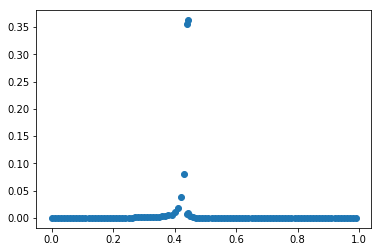

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


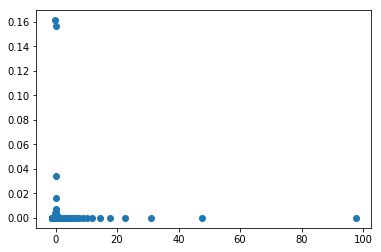

[-1.65420873 -7.94776262]
[ -1.71979981 -11.9582317 ]
1.75


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


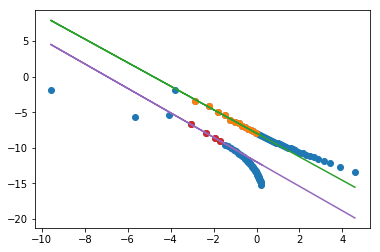

In [273]:
betas,M,e=GetMe('M',data)
betas,M2,e=GetMe('M2',data)
plt.plot(betas,M2-M**2,'o')
plt.show()
t=1/betas
plt.plot((t-tc),(1/t)*(M2-M**2),'o')
#plt.xlim(2,2.4)
plt.show()
xx=np.log(np.abs(tc-t))
yy=np.log((1/t)*(M2-M**2))
plt.plot(xx,yy,'o')
#plt.xlim(2,2.4)
#cut=np.logical_and(-4.5<yy,np.logical_and(xx<-1,xx>-5))
##cut=np.logical_and(tc-t>0,np.logical_and(xx>-3.5,xx<-1.5))
cut=np.logical_and(tc-t<0,np.logical_and(-3.5<xx,xx<0))

plt.plot(xx[cut],yy[cut],'o')
line=np.polyfit(xx[cut],yy[cut],1)
plt.plot(xx,line[0]*xx+line[1])
print(line)

cut=np.logical_and(tc-t>0,np.logical_and(xx>-3.5,xx<-1.5))
plt.plot(xx[cut],yy[cut],'o')
line=np.polyfit(xx[cut],yy[cut],1)
plt.plot(xx,line[0]*xx+line[1])
print(line)

print(7/4.)
plt.show()
#plt.plot(x,y,'o')

#cut=np.logical_and(np.logical_and(x>0.440,x<0.5),y>0.4)
#cut=np.logical_and(x>0.445, x<0.5)
#plt.plot(x[cut],y[cut],'o')
#plt.xlim(0.4,0.5)
#plt.show()

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.30000000000000004
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.444
0.445
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6000000000000001
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99


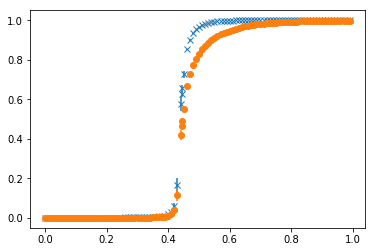

In [215]:

x=[]
y=[]
error=[]
keys=list(data.keys())
keys.sort()
for key in keys:
    print(key)
    x.append(key)
    y.append(data[key]['M2_coarse'][0])
    error.append(data[key]['M2_coarse'][2])
plt.errorbar(x,y,error,fmt='x')





x=[]
y=[]
error=[]
keys=list(data.keys())
keys.sort()
for key in keys:
    x.append(key)
    y.append(data[key]['M2'][0])
    error.append(data[key]['M2'][2])
plt.errorbar(x,y,error,fmt='o')




plt.show()


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


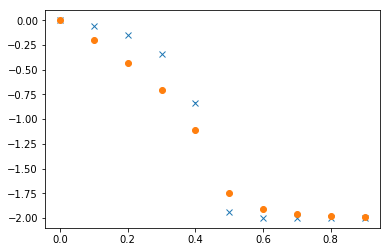

In [151]:

x=[]
y=[]
error=[]
keys=list(data.keys())
keys.sort()
for key in keys:
    print(key)
    x.append(key)
    y.append(data[key]['E_coarse'][0])
    error.append(data[key]['E_coarse'][2])
plt.errorbar(x,y,error,fmt='x')





x=[]
y=[]
error=[]
keys=list(data.keys())
keys.sort()
for key in keys:
    x.append(key)
    y.append(data[key]['E'][0])
    error.append(data[key]['E'][2])
plt.errorbar(x,y,error,fmt='o')




plt.show()


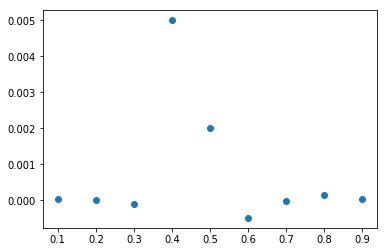

In [23]:
import pylab as plt
betas=np.arange(0,1,0.1)
#plt.plot(betas,myData2,'o')
#plt.plot(betas,myData,'o')
plt.plot(betas[1:],myData2[1:]-myData[1:],'o')

In [70]:
myO

[-0.00010011012113324657,
 -3.4834843247554024e-05,
 3.6116545758633535e-05,
 4.4569678986467494e-05,
 -4.4539162260013214e-05,
 4.7316184367352174e-05,
 3.7947549345889986e-05,
 -2.8121163427613694e-05,
 6.068251055432428e-05,
 -2.5832408943543124e-05,
 -3.4041408359742886e-05,
 -4.832323634034322e-05,
 5.264135313362302e-06,
 4.371521064574782e-05,
 -5.442658163119806e-05,
 -0.00010059838875651495,
 -0.00014042271677934282,
 0.0001468312293347404,
 0.00016678916843583576,
 5.3053328940755726e-05,
 0.00014225372036659928,
 0.0003926739776503735,
 -0.00022031550663663272,
 0.0001083496372759006,
 0.00027048500492745953,
 -0.00040420930025008916,
 1.8233744056428845e-05,
 0.00011375109785830715,
 0.00023691660582775788,
 -0.00044855010378814955,
 -1.7745476433160458e-05,
 -0.0013104950424891247,
 7.630707449891268e-05,
 3.2393505131212086e-05,
 0.0016419982419619058,
 0.000710353100039368,
 -0.0009874144595177238,
 -0.005454910628791197,
 -0.005490462615110427,
 -0.0038060308650138533,


In [71]:
myO=-np.array(myO)

In [76]:
backup=np.copy(myO)

In [77]:
for i in range(0,len(myO)):
    myO[i]=np.abs(myO[i])

(0.4, 0.5)

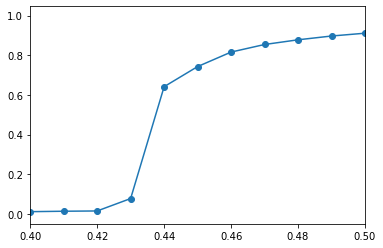

In [85]:
beta=np.arange(0,0.82,0.01)
plt.plot(beta[1:],myO[1:],'o-')
plt.xlim(0.4,0.5)

In [112]:
print(len(x))
print(len(y))

207
207


In [110]:
import pylab as plt
betas=np.arange(0,0.82,0.01)
line=np.polyfit(np.log(1-(0.4406/betas))[45:47],np.log(myData)[45:47],1)
print(line)
plt.plot(np.log(1-(0.4406/betas)),np.log(myData),'o')
#plt.plot((1-(0.44/betas)),(myData),'o')
plt.plot(np.log((1-(0.4406/betas))),line[0]*np.log(1-(0.4406/betas))+line[1])
plt.show()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: expected x and y to have same length

In [58]:
1/2.2222

0.4500045000450005

In [59]:
np.log(1+np.sqrt(2))/2.

0.44068679350977147

In [90]:
0.259/2.

0.1295

In [67]:
0.2206/2.

0.1103

In [93]:
1/8.

0.125

In [5]:
1/(1+0.01831563888873418)

0.9820137900379085

In [104]:
print(data.keys())

dict_keys([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 0.401, 0.402, 0.403, 0.404, 0.405, 0.406, 0.40700000000000003, 0.40800000000000003, 0.40900000000000003, 0.41100000000000003, 0.41200000000000003, 0.41300000000000003, 0.41400000000000003, 0.41500000000000004, 0.41600000000000004, 0.41700000000000004, 0.4

In [105]:
print(x)

[0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
 0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
 0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
 0.36  0.37  0.38  0.39  0.4   0.401 0.402 0.403 0.404 0.405 0.406 0.407
 0.408 0.409 0.41  0.411 0.412 0.413 0.414 0.415 0.416 0.417 0.418 0.419
 0.42  0.42  0.421 0.422 0.423 0.424 0.425 0.426 0.427 0.428 0.429 0.43
 0.43  0.431 0.432 0.433 0.434 0.435 0.436 0.437 0.438 0.439 0.44  0.44
 0.441 0.441 0.442 0.442 0.443 0.443 0.444 0.444 0.445 0.445 0.446 0.446
 0.447 0.447 0.448 0.448 0.449 0.449 0.45  0.45  0.451 0.452 0.453 0.454
 0.455 0.456 0.457 0.458 0.459 0.46  0.46  0.461 0.462 0.463 0.464 0.465
 0.466 0.467 0.468 0.469 0.47  0.47  0.471 0.472 0.473 0.474 0.475 0.476
 0.477 0.478 0.479 0.48  0.48  0.481 0.482 0.483 0.484 0.485 0.486 0.487
 0.488 0.489 0.49  0.49  0.491 0.492 0.493 0.494 0.495 0.496 0.497 0.498
 0.499 0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0

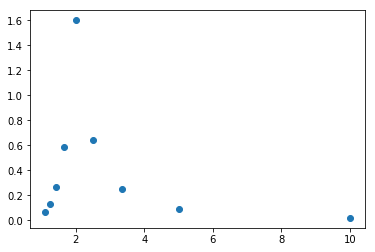

In [158]:

x=[]
y=[]
keys=list(data.keys())
keys.sort()
for key in keys:
    x.append(key)
    y.append(np.abs(data[key]['E'][0]))
x=np.array(x)
y=np.array(y)  
y=(y[1:]-y[:-1])/(x[1:]-x[:-1])
y=y*x[1:]**2
plt.plot(1./x[1:],y,'o')
#cut=np.logical_and(np.logical_and(x>0.4450,x<0.5),y>0.4)
#plt.plot(x[cut],y[cut],'o')
#plt.xlim(0.4,0.5)
plt.show()

In [279]:
f.close()

In [280]:
f=open('data.pickle','rb')
data3=pickle.load(f)

In [281]:
print(data3)

{0.0: {'M2': (0.00015405490267785275, 4.784584548906587e-08, 2.1885733681174556e-06, 1.0), 'M': (0.00028989364295237797, 0.00015397086435362854, 0.00012415329992163893, 1.0), 'E': (-0.00011507857545906805, 0.0003057317880739819, 0.00017494812470664095, 1.0), 'M2_coarse': (0.0013904710940321726, 3.9902355252021575e-06, 2.073886356502502e-05, 1.076696723155936), 'E_coarse': (0.0003238129844063035, 0.0027524383168772443, 0.000534477102796102, 1.0367227462023691)}, 0.1: {'M2': (0.00023635134637809148, 1.110810645739396e-07, 3.5341973216265082e-06, 1.1232167381784457), 'M': (0.00015928205372808428, 0.00023632597560545163, 0.0001932348415465875, 1.5782704468940343), 'E': (-0.20351943608019119, 0.0003264816398191525, 0.00018303342897798273, 1.0250005109702138), 'M2_coarse': (0.0015159664222040088, 4.503955296890618e-06, 2.1785883283670034e-05, 1.0526361653622618), 'E_coarse': (-0.05554779667785456, 0.002764344278139279, 0.0005395422286631628, 1.0519152857052334)}, 0.2: {'M2': (0.0004261458497

In [7]:
f=open('data.pickle','rb')
data=pickle.load(f)

In [17]:
def GetAutocorrelation(s,data):
    x=[]
    y=[]
    error=[]
    keys=list(data.keys())
    keys.sort()
    for key in keys:
        x.append(key)
        y.append(data[key][s][3])
        #error.append(data[key][s][2])
    return (np.array(x),np.array(y)) #np.array(error))

x,y=GetAutocorrelation('M2',data3)

(0.3, 0.5)

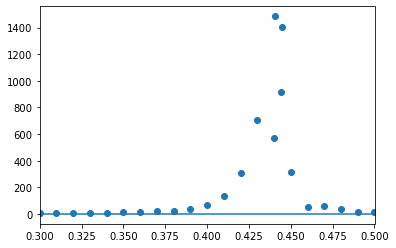

In [19]:
import pylab as plt
plt.plot(x,y,'o')
plt.axhline(0.0)
plt.xlim(0.3,0.5)